In [127]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from keras.utils import np_utils
import cv2
from PIL import Image
import glob
import random
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization,MaxPool2D

In [128]:
categories = ['daisy', 'dandelion', 'rose','sunflower','tulip']

In [129]:
images_shapes = {"height": [], "width": []}
#
for cat in categories:
    filelist = glob.glob('flowers/' + cat + '/*.jpg')
    for fname in filelist:
        images_shapes["height"].append(np.array(Image.open(fname)).shape[0])
        images_shapes["width"].append(np.array(Image.open(fname)).shape[1])

In [130]:
display("Average height: " + str(int(np.mean(images_shapes["height"]))))
display("Average width: " + str(int(np.mean(images_shapes["width"]))))

'Average height: 253'

'Average width: 338'

In [131]:
im_width = int(338/2)
im_height = int(253/2)
display("Used height: " + str(im_height))
display("Used width: " + str(im_width))

'Used height: 126'

'Used width: 169'

In [132]:
data = []
target = []
for cat in categories:
    filelist = glob.glob('flowers/' + cat + '/*.jpg')
#     print(filelist)
    target.extend([cat for _ in filelist])
    data.extend([np.array(Image.open(fname).resize((im_width, im_height))) for fname in filelist])
#
data_array = np.stack(data, axis=0)

In [133]:
data_array.shape

(4317, 126, 169, 3)

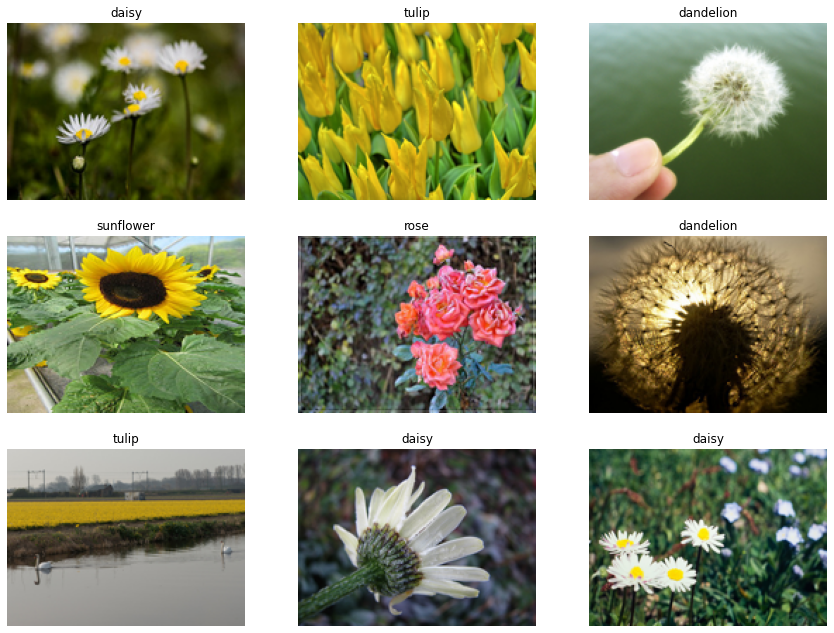

In [134]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image])

**IMAGE AUGMENTATION**

In [ ]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest"
                            ) 
#
# datagen.fit(X_train_norm)

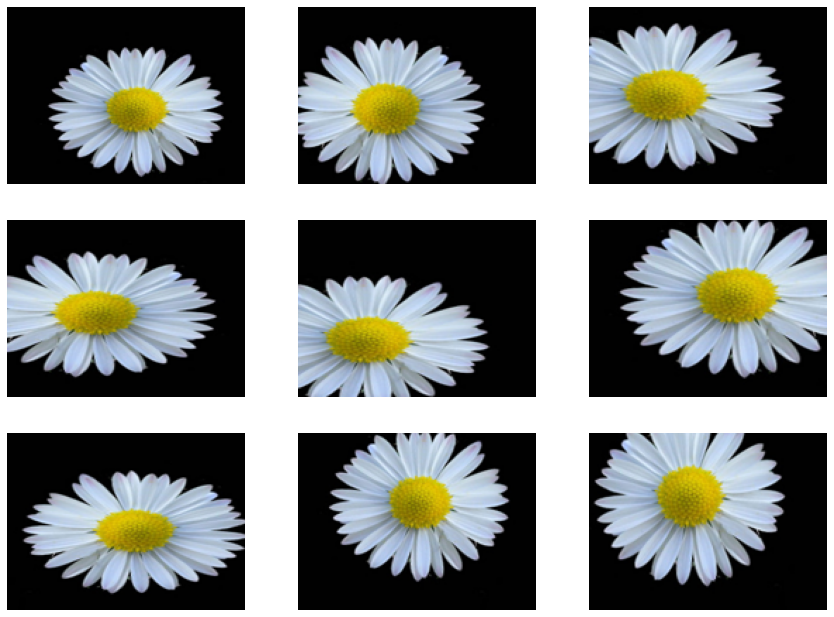

In [156]:
# X_augmented = datagen.flow(X_train_norm, shuffle=False, batch_size=1)
from skimage import io
import shutil
directory = "daisy"
x = io.imread("flowers/" + directory + "/21652746_cc379e0eea_m.jpg")
x = x.reshape((1, ) + x.shape)
i=0
for batch in datagen.flow(x, batch_size=9, save_to_dir = 'augmented/'+directory, save_format='png'):
    i+=1
    if i>9:
        break

data=[]
filelist = glob.glob('augmented/' + directory + '/*.png')
data.extend([np.array(Image.open(fname).resize((im_width, im_height))) for fname in filelist])
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
data_array = np.stack(data, axis=0)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
#         ax.set_title(target[num_image])
        ax.imshow(data_array[num_image])

**TRAIN TEST SPLIT**

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, 
                                                    stratify=target)
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

In [140]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3453, 126, 169, 3)
(864, 126, 169, 3)
(3453,)
(864,)


In [141]:
encoder = LabelEncoder().fit(y_train)
encoder

LabelEncoder()

In [142]:
y_train_categorical = encoder.transform(y_train)
y_test_categorical = encoder.transform(y_test)
y_train_categorical

array([1, 2, 2, ..., 2, 1, 1])

In [144]:
y_train_onehot = np_utils.to_categorical(y_train_categorical)
y_test_onehot = np_utils.to_categorical(y_test_categorical)
y_train_onehot

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

**CREATING THE MODEL AND ADDING LAYERS**

In [145]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 3), padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
model.add(layers.MaxPool2D(pool_size=(3, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(5, activation='softmax'))

In [121]:
# input_shape = (im_width,im_height,3)
# model.build(input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 169, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 84, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 63, 84, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 31, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 31, 42, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 14, 128)     

**COMPILING AND FITTING THE MODEL**

In [158]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics="accuracy")

train_flow = datagen.flow(X_train_norm, y_train_onehot, batch_size=16)

history = model.fit(train_flow,validation_data=(X_test_norm,y_test_onehot),batch_size=32,epochs=100,validation_split=0.3,callbacks=[es])

Epoch 1/100
216/216 [==============================] - 47s 213ms/step - loss: 0.9521 - accuracy: 0.6386 - val_loss: 0.8162 - val_accuracy: 0.6863
Epoch 2/100
216/216 [==============================] - 48s 224ms/step - loss: 0.8805 - accuracy: 0.6710 - val_loss: 0.8379 - val_accuracy: 0.6875
Epoch 3/100
216/216 [==============================] - 48s 223ms/step - loss: 0.8547 - accuracy: 0.6710 - val_loss: 0.7772 - val_accuracy: 0.6968
Epoch 4/100
216/216 [==============================] - 50s 233ms/step - loss: 0.8058 - accuracy: 0.6939 - val_loss: 0.7761 - val_accuracy: 0.7049
Epoch 5/100
216/216 [==============================] - 51s 234ms/step - loss: 0.7869 - accuracy: 0.7043 - val_loss: 0.8134 - val_accuracy: 0.6655
Epoch 6/100
216/216 [==============================] - 52s 240ms/step - loss: 0.7606 - accuracy: 0.7029 - val_loss: 0.7751 - val_accuracy: 0.7083
Epoch 7/100
216/216 [==============================] - 55s 256ms/step - loss: 0.7367 - accuracy: 0.7286 - val_loss: 0.7413 -

**SAVING THE MODEL**

In [160]:
model.save('flower_classifcation_model')

INFO:tensorflow:Assets written to: flower_classifcation_model\assets


INFO:tensorflow:Assets written to: flower_classifcation_model\assets


**LOADING AND TESTING THE MODEL**

In [183]:
from keras.models import load_model
model = load_model('flower_classifcation_model')
y_pred = model.predict(X_test_norm)

dict = {
    0 : 'daisy',
    1 : 'dandelion',
    2 : 'rose',
    3 : 'sunflower',
    4 : 'tulip'
}
result = []
for pred in y_pred:
    loc = np.where(pred==max(pred))
#     print(loc)
    result.append(loc[0][0])
    print("The predicted result is: " + dict[loc[0][0]])
        

27/27 [==============================] - 3s 93ms/step
The predicted result is: sunflower
The predicted result is: sunflower
The predicted result is: daisy
The predicted result is: dandelion
The predicted result is: rose
The predicted result is: rose
The predicted result is: sunflower
The predicted result is: daisy
The predicted result is: dandelion
The predicted result is: sunflower
The predicted result is: sunflower
The predicted result is: tulip
The predicted result is: dandelion
The predicted result is: dandelion
The predicted result is: daisy
The predicted result is: dandelion
The predicted result is: daisy
The predicted result is: rose
The predicted result is: dandelion
The predicted result is: dandelion
The predicted result is: daisy
The predicted result is: rose
The predicted result is: daisy
The predicted result is: tulip
The predicted result is: dandelion
The predicted result is: tulip
The predicted result is: sunflower
The predicted result is: daisy
The predicted result is: s

In [185]:
from sklearn.metrics import accuracy_score
print(accuracy_score(result,y_test_categorical))

0.7719907407407407


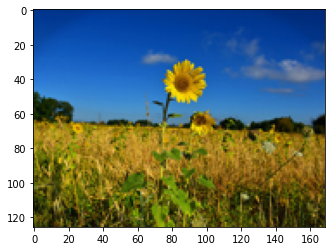

In [189]:
plt.imshow(X_test[1])